In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals, moving_average
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen import get_simu_data
from torch.utils.data import DataLoader
from gan.utils import MyDataSet
from models.ddpm import ContextNet, ddpm_schedules, DDPM
from ddpm.train_ddpm import TrainDDPM

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed

In [5]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np

In [6]:
torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.FloatTensor)

In [7]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [8]:
n = 500
d = 10
rho = 0.9
is_homo = True
dftype = torch.get_default_dtype();

data = get_simu_data(n=n, d=d, rho=rho, is_homo=is_homo);
data_test = get_simu_data(n=1000, d=d, rho=rho, is_homo=is_homo);

data_train = MyDataSet(Y=data.Y1, X=data.X);
data_test_input = edict()
data_test_input.c = data_test.X
data_test_input.x = data_test.Y1;

In [13]:
myddpm = TrainDDPM(data_train, save_dir="test", verbose=True, test_intv=50);

2023-12-16 11:44:18,263 - ddpm.train_ddpm - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/test.
2023-12-16 11:44:18,279 - ddpm.train_ddpm - INFO - The params is {'lr': 0.0001, 'batch_size': 128, 'device': 'cpu', 'n_T': 400, 'n_infeat': 256, 'n_upblk': 1, 'n_downblk': 1, 'betas': [0.0001, 0.02], 'drop_prob': 0.1, 'lr_gamma': 0.9, 'lr_step': 1000, 'test_intv': 50}


The num of params is 1.19m. 
Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
myddpm.train(n_epoch=100, data_test=data_test_input, save_snapshot=True)

AssertionError: if you want to save model, plz provide save dir

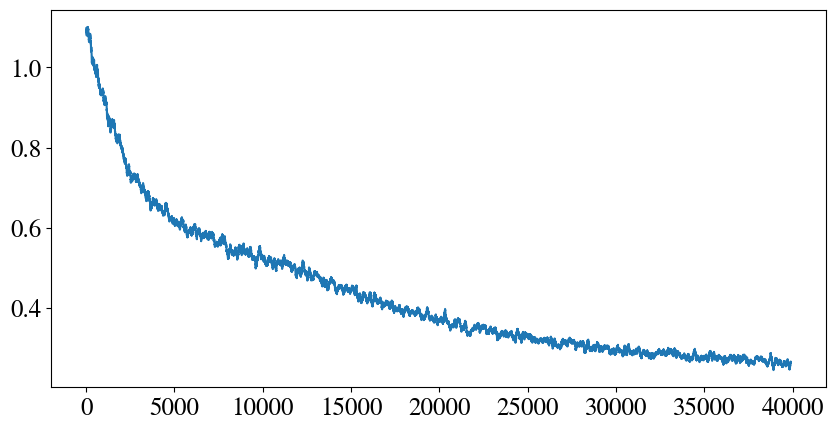

In [11]:
plt.plot(moving_average(myddpm.losses, 100))

# evaluate

In [12]:
ddpm = myddpm.ddpm;

## ON test set

In [13]:
tX = torch.tensor(data_test.X);
c = tX.type(dftype);

In [26]:
torch.tensor([1, 2], dtype=dftype)

tensor([1., 2.])

In [14]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(c, device="cpu", guide_w=0, is_store=False);

100%|██████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 83.87it/s]


(-10.0, 10.0)

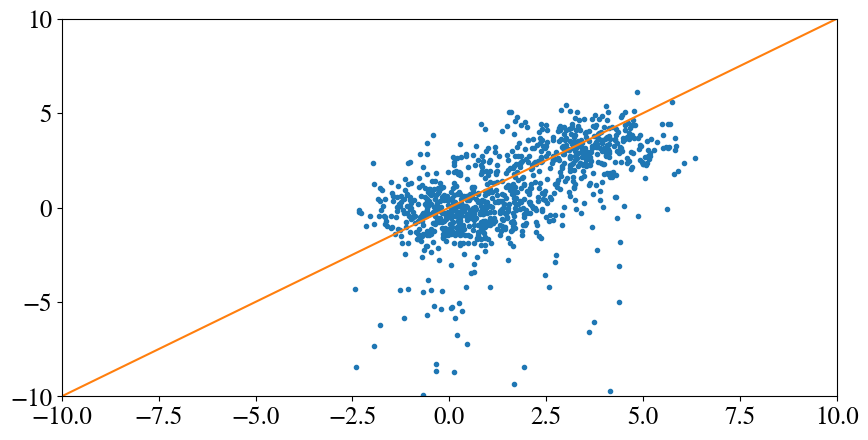

In [15]:
predx0 = x_i.reshape(-1).numpy();
x0 = data_test.Y1;
plt.plot(x0, predx0, ".")
xx = np.linspace(-10, 10, 100)
yy = xx
plt.plot(xx, yy)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

## Given X

In [22]:
datatest_con = get_simu_data(1000, d, rho=rho, is_homo=is_homo, is_condition=True);
tX_con = torch.tensor(datatest_con.X);
c = tX_con.type(dftype);

In [23]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(c, device="cpu", guide_w=0);

100%|██████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 88.90it/s]


(-5.0, 10.0)

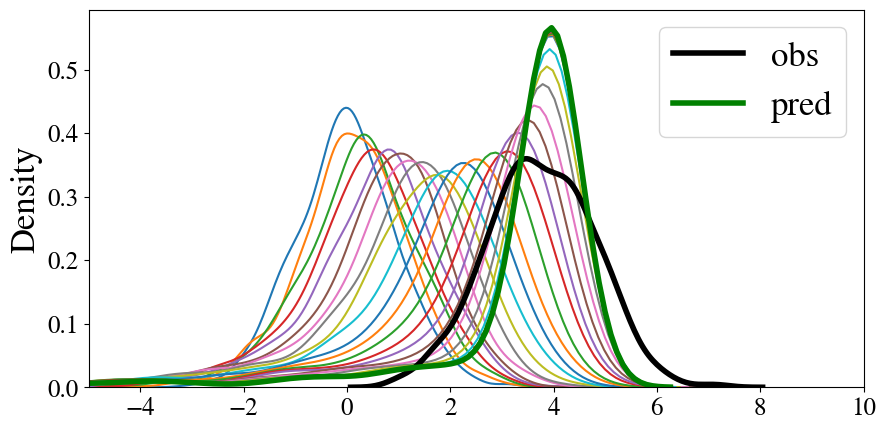

In [24]:
predx0 = x_i.reshape(-1).numpy();
x0 = datatest_con.Y1;
x_is = x_is.squeeze();
for idx in range(x_is.shape[0]):
    sns.kdeplot(x_is[idx])
sns.kdeplot(x0, color="black", lw=4, label="obs")
sns.kdeplot(predx0, color="green", lw=4, label="pred")
plt.legend()
plt.xlim([-5, 10])